In [1]:
!pip install volumentations-3D
!pip install MedPy
from volumentations import *
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.8 MB/s eta 0:00:00
  Created wheel for MedPy: filename=MedPy-0.4.0-py3-none-any.whl size=214964 sha256=15ea6dac6693d33704290173ea10faa628704c9d9890a176744bae0a3b912e73
  Stored in directory: /root/.cache/pip/wheels/fc/38/7d/e0b8bcb2770f779a93cab5ab7fa6dd344011e1278cb90cab86
Successfully built MedPy


In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import tensorflow as tf
import keras.backend as K
from keras.utils import to_categorical
from keras import metrics
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
# from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight


from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize



import os
import cv2
import glob
import PIL
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# ml libs
import keras
from keras.models import Model
from keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


In [ ]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)

  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)
  
  return X

In [ ]:
def Unet_3d(input_img, n_filters = 8, dropout = 0.2, batch_norm = True):

  c1 = conv_block(input_img,n_filters,3,batch_norm)
  p1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(c1)
  p1 = Dropout(dropout)(p1)
  
  c2 = conv_block(p1,n_filters*2,3,batch_norm);
  p2 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv_block(p2,n_filters*4,3,batch_norm);
  p3 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv_block(p3,n_filters*8,3,batch_norm);
  p4 = MaxPooling3D(pool_size=(2,2,2) ,strides=2)(c4)
  p4 = Dropout(dropout)(p4)
  
  c5 = conv_block(p4,n_filters*16,3,batch_norm);

  u6 = Conv3DTranspose(n_filters*8, (3,3,3), strides=(2, 2, 2), padding='same')(c5);
  u6 = concatenate([u6,c4]);
  c6 = conv_block(u6,n_filters*8,3,batch_norm)
  c6 = Dropout(dropout)(c6)
  u7 = Conv3DTranspose(n_filters*4,(3,3,3),strides = (2,2,2) , padding= 'same')(c6);

  u7 = concatenate([u7,c3]);
  c7 = conv_block(u7,n_filters*4,3,batch_norm)
  c7 = Dropout(dropout)(c7)
  u8 = Conv3DTranspose(n_filters*2,(3,3,3),strides = (2,2,2) , padding='same')(c7);
  u8 = concatenate([u8,c2]);

  c8 = conv_block(u8,n_filters*2,3,batch_norm)
  c8 = Dropout(dropout)(c8)
  u9 = Conv3DTranspose(n_filters,(3,3,3),strides = (2,2,2) , padding='same')(c8);

  u9 = concatenate([u9,c1]);

  c9 = conv_block(u9,n_filters,3,batch_norm)
  outputs = Conv3D(4, (1, 1,1), activation='softmax')(c9)
  print("3D U Net Model By Wagaye Tadele")
  print(outputs.shape)
  model = Model(inputs=input_img, outputs=outputs)

  return model


In [ ]:
from scipy import ndimage
from medpy.metric.binary import hd95


def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def dice_coef_wt(y_true, y_pred):
    y_true_wt = y_true[:,:,:,:,1] + y_true[:,:,:,:,2] + y_true[:,:,:,:,3]
    y_pred_wt = y_pred[:,:,:,:,1] + y_pred[:,:,:,:,2] + y_pred[:,:,:,:,3]
    return dice_coef(y_true_wt, y_pred_wt)

def dice_coef_tc(y_true, y_pred):
    y_true_tc = y_true[:,:,:,:,1] + y_true[:,:,:,:,3]
    y_pred_tc = y_pred[:,:,:,:,1] + y_pred[:,:,:,:,3]
    return dice_coef(y_true_tc, y_pred_tc)

def dice_coef_et(y_true, y_pred):
    y_true_et = y_true[:,:,:,:,3]
    y_pred_et = y_pred[:,:,:,:,3]
    return dice_coef(y_true_et, y_pred_et)

#def precision(y_true, y_pred):
    #true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    #predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    #precision = true_positives / (predicted_positives + K.epsilon())
   # return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (actual_positives + K.epsilon())
    return sensitivity

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / negatives

#def precision_wt(y_true, y_pred):
 # y_true_wt = y_true[:,:,:,:,1] + y_true[:,:,:,:,2] + y_true[:,:,:,:,3]
 # y_pred_wt = y_pred[:,:,:,:,1] + y_pred[:,:,:,:,2] + y_pred[:,:,:,:,3]
 # return precision(y_true_wt, y_pred_wt)

#def precision_tc(y_true, y_pred):
 # y_true_tc = y_true[:,:,:,:,1] + y_true[:,:,:,:,3]
 # y_pred_tc = y_pred[:,:,:,:,1] + y_pred[:,:,:,:,3]
 # return precision(y_true_tc, y_pred_tc)

#def precision_et(y_true, y_pred):
 # y_true_et = y_true[:,:,:,:,3]
 # y_pred_et = y_pred[:,:,:,:,3]
 # return precision(y_true_et, y_pred_et)

def sensitivity_wt(y_true, y_pred):
  y_true_wt = y_true[:,:,:,:,1] + y_true[:,:,:,:,2] + y_true[:,:,:,:,3]
  y_pred_wt = y_pred[:,:,:,:,1] + y_pred[:,:,:,:,2] + y_pred[:,:,:,:,3]
  return sensitivity(y_true_wt, y_pred_wt)

def sensitivity_tc(y_true, y_pred):
  y_true_tc = y_true[:,:,:,:,1] + y_true[:,:,:,:,3]
  y_pred_tc = y_pred[:,:,:,:,1] + y_pred[:,:,:,:,3]
  return sensitivity(y_true_tc, y_pred_tc)

def sensitivity_et(y_true, y_pred):
  y_true_et = y_true[:,:,:,:,3]
  y_pred_et = y_pred[:,:,:,:,3]
  return sensitivity(y_true_et, y_pred_et)

def specificity_wt(y_true, y_pred):
  y_true_wt = y_true[:,:,:,:,1] + y_true[:,:,:,:,2] + y_true[:,:,:,:,3]
  y_pred_wt = y_pred[:,:,:,:,1] + y_pred[:,:,:,:,2] + y_pred[:,:,:,:,3]
  return specificity(y_true_wt, y_pred_wt)

def specificity_tc(y_true, y_pred):
  y_true_tc = y_true[:,:,:,:,1] + y_true[:,:,:,:,3]
  y_pred_tc = y_pred[:,:,:,:,1] + y_pred[:,:,:,:,3]
  return specificity(y_true_tc, y_pred_tc)

def specificity_et(y_true, y_pred):
  y_true_et = y_true[:,:,:,:,3]
  y_pred_et = y_pred[:,:,:,:,3]
  return specificity(y_true_et, y_pred_et)

# Set voxel spacing according to your dataset
# Our Dataset voxel spacing is 0.1 mm but we 
# set voxel spacing to default which is unit
# which means we have to devide our HD95 results by 10

def HD95(y_true, y_pred):
  #y_true = tf.keras.backend.eval(y_true)
  #y_pred = tf.keras.backend.eval(y_pred)
  return hd95(y_true, y_pred)

def HD95_wt(y_true, y_pred):
  #y_true = tf.keras.backend.eval(y_true)
  #y_pred = tf.keras.backend.eval(y_pred)
  y_true_wt = y_true[:,:,:,:,1] + y_true[:,:,:,:,2] + y_true[:,:,:,:,3]
  y_pred_wt = y_pred[:,:,:,:,1] + y_pred[:,:,:,:,2] + y_pred[:,:,:,:,3]
  return hd95(y_true_wt, y_pred_wt)

def HD95_tc(y_true, y_pred):
  #y_true = tf.keras.backend.eval(y_true)
  #y_pred = tf.keras.backend.eval(y_pred)
  y_true_tc = y_true[:,:,:,:,1] + y_true[:,:,:,:,3]
  y_pred_tc = y_pred[:,:,:,:,1] + y_pred[:,:,:,:,3]
  return hd95(y_true_tc, y_pred_tc)

def HD95_et(y_true, y_pred):
  #y_true = tf.keras.backend.eval(y_true)
  #y_pred = tf.keras.backend.eval(y_pred)
  #y_true_et_binary = np.where(y_true > 0.5, 1, 0)
  #y_pred_et_binary = np.where(y_pred > 0.5, 1, 0)

  try:
    y_true_et = y_true[:,:,:,:,3] #+ y_true[:,:,:,:,0]
    y_pred_et = y_pred[:,:,:,:,3] #+ y_pred[:,:,:,:,0]
  
    return hd95(y_true_et, y_pred_et)
  except RuntimeError:
    return 1

#def HD95_zero(y_true, y_pred):
  #y_true = tf.keras.backend.eval(y_true)
  #y_pred = tf.keras.backend.eval(y_pred)
  #y_true_et_binary = np.where(y_true > 0.5, 1, 0)
  #y_pred_et_binary = np.where(y_pred > 0.5, 1, 0)

  #y_true_zero = y_true[:,:,:,:,0]
  #y_pred_zero = y_pred[:,:,:,:,0]
  
  #return hd95(y_true_zero, y_pred_zero)

In [ ]:
def get_augmentation(patch_size):
    return Compose([
        Rotate((0, 90, 180, 270), (0, 0, 0), (0, 0, 0), p= 1),
        #ElasticTransform((0, 1), interpolation=2, p=0.2),
        Flip(0, p=1/3),
        Flip(1, p=1/3),
        Flip(2, p=1/3)
        #GaussianNoise(var_limit=(0, 0.001), p=0.2)
        #Resize(patch_size, interpolation=1, resize_type=0, always_apply=True, p=1.0)
    ], p=1.0)

In [ ]:
input_img = Input((128,128,128,4))
model = Unet_3d(input_img,32,0.1,True)

In [ ]:
model.compile(run_eagerly=True,loss = dice_coef_loss, optimizer = keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ['accuracy',tf.keras.metrics.OneHotMeanIoU(num_classes=4), dice_coef,
                         dice_coef_wt, dice_coef_tc ,dice_coef_et,
                         sensitivity, specificity, 
                         sensitivity_wt,
                         sensitivity_tc, sensitivity_et,
                         specificity_wt, specificity_tc,
                         specificity_et, HD95, HD95_wt,
                         HD95_tc, HD95_et
                         ])

In [ ]:
print(model.input_shape)

(None, 128, 128, 128, 4)


In [ ]:
print(model.output_shape)

(None, 128, 128, 128, 4)


In [ ]:
model.summary()

In [3]:
def load_images(img_dir, img_list, random_number):
    
    images = []
    
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):
            number = (image_name.split('.')[0]).split('_')[1]
            random.seed(int(number) + random_number)
            
            image = np.load(img_dir + image_name)

            aug = get_augmentation((128, 128, 128))

            img = image

            # with mask
            data = {'image': img}
            aug_data = aug(**data)
            img = aug_data['image']
            
            images.append(img)
    images = np.array(images)
    
    return images

In [4]:
def image_loader(img_dir, img_list, mask_dir, mask_list, batch_size):
    
    L = len(img_list)
    
    while True:
        
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:
            
            limit = min(batch_end, L)
            random_number = random.randint(1, 10000)
            
            x = load_images(img_dir, img_list[batch_start:limit], random_number)
            y = load_images(mask_dir, mask_list[batch_start:limit], random_number)
            
            yield (x,y)
            
            batch_start += batch_size
            batch_end += batch_size
    

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_img_dir = '/content/drive/MyDrive/3D U Net paper/Dataset/Training/Images/'
train_mask_dir = '/content/drive/MyDrive/3D U Net paper/Dataset/Training/Masks/'
train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_dir = '/content/drive/MyDrive/3D U Net paper/Dataset/Validation/Images/'
val_mask_dir = '/content/drive/MyDrive/3D U Net paper/Dataset/Validation/Masks/'
val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [7]:
batch_size = 2

train_image_datagen = image_loader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

val_image_datagen = image_loader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

In [8]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [ ]:
img, mask = train_image_datagen.__next__()
print(img.shape, mask.shape)

In [ ]:
csv_logger = CSVLogger('/content/drive/MyDrive/3D U Net paper/New 1/New 1 History.csv', separator=',', append=True)

callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr = 0.000001, verbose = 1),
             ModelCheckpoint('/content/drive/MyDrive/3D U Net paper/New 1/New weights.{epoch:02d}-{val_loss:.3f}.hdf5', monitor='val_loss', save_best_only=False),
             csv_logger
]


In [ ]:
# Load the model to continue training
from keras.models import load_model

tf.config.experimental_run_functions_eagerly(True)
model = load_model('/content/drive/MyDrive/3D U Net paper/New 1/New 12 model.hdf5', compile = False)

In [ ]:
model.compile(loss = dice_coef_loss, optimizer = keras.optimizers.Adam(learning_rate=0.0000008),
              metrics = ['accuracy',tf.keras.metrics.OneHotMeanIoU(num_classes=4), dice_coef,
                         dice_coef_wt, dice_coef_tc ,dice_coef_et,
                         sensitivity, specificity, 
                         sensitivity_wt,
                         sensitivity_tc, sensitivity_et,
                         specificity_wt, specificity_tc,
                         specificity_et, HD95, HD95_wt,
                         HD95_tc, HD95_et
                         ])

In [ ]:
history =  model.fit(train_image_datagen,
                    epochs = 3,
                    verbose = 1,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = val_steps_per_epoch,
                    callbacks= callbacks,
                    validation_data = val_image_datagen
                    )  
model.save("/content/drive/MyDrive/3D U Net paper/New 1/New 13 model.hdf5")

In [11]:
# Load the model
from keras.models import load_model

model = load_model('/content/drive/MyDrive/3D U Net paper/New 1/New 12 model.hdf5', compile = False)

In [14]:
# Take a specific array of size [128,128,128,4] and make a prediction using the loaded model
num_img = 120
  
test_img = np.load('/content/drive/MyDrive/3D U Net paper/Dataset/Validation/Images/Image_'+ str(num_img)+'.npy')
test_mask = np.load('/content/drive/MyDrive/3D U Net paper/Dataset/Validation/Masks/Mask_'+ str(num_img)+'.npy')
test_mask_argmax = np.argmax(test_mask, axis = 3)

test_img_input = np.expand_dims(test_img, axis = 0)
test_prediction = model.predict(test_img_input)

test_pred_argmax = np.argmax(test_prediction, axis = 4)[0,:,:,:]

1/1 [==============================] - 0s 76ms/step


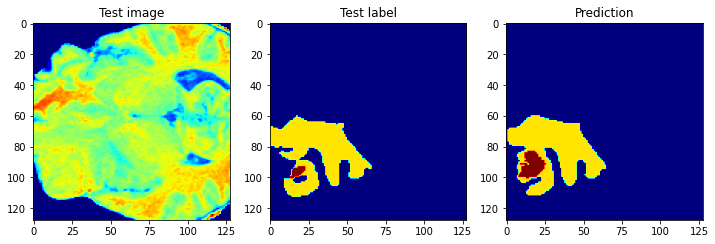

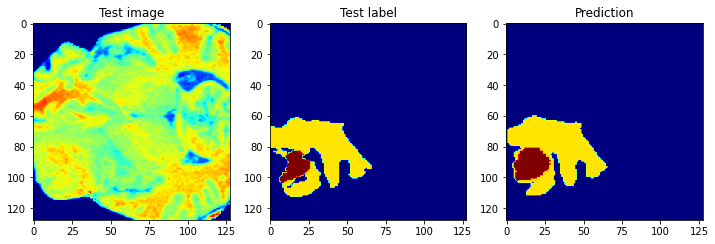

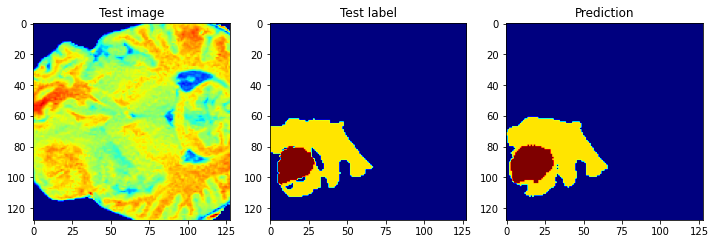

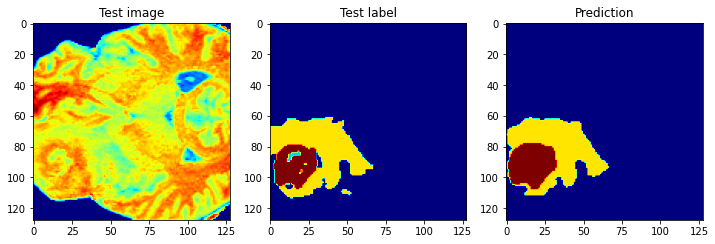

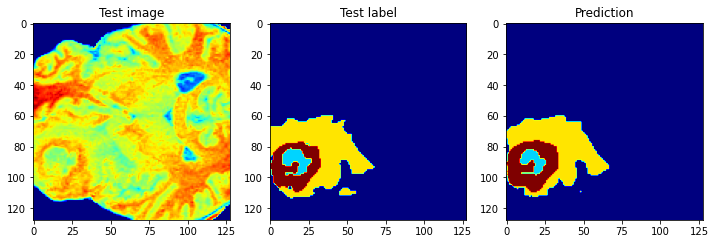

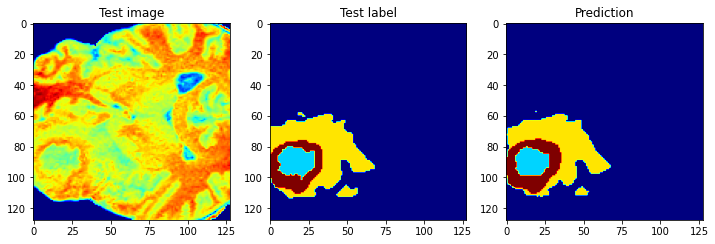

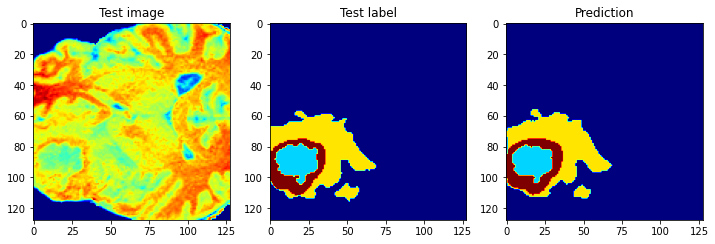

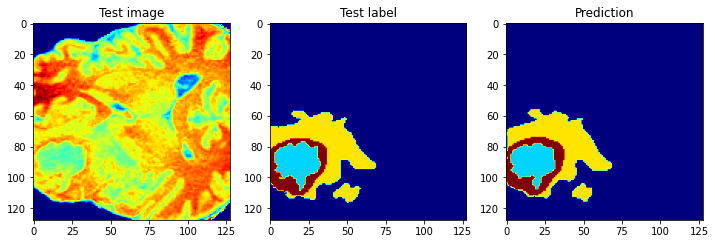

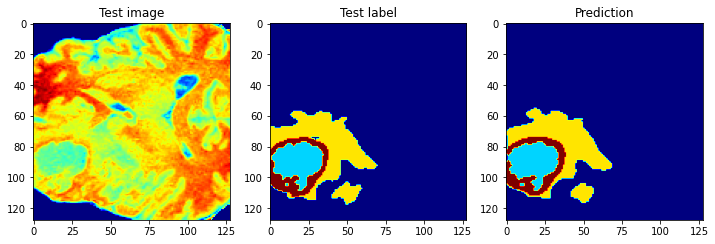

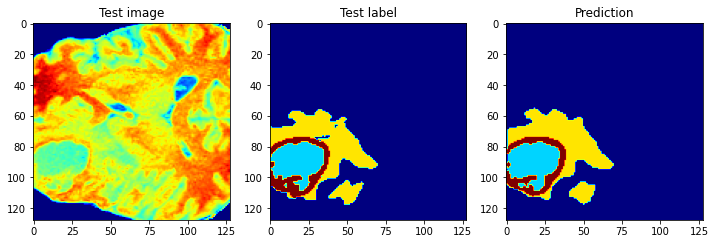

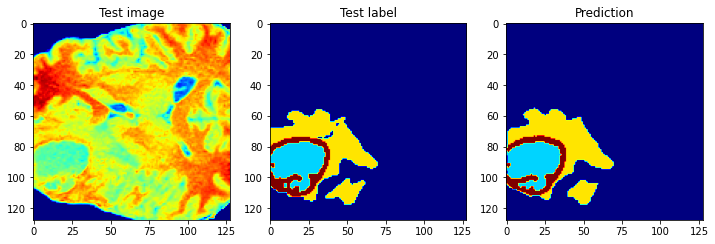

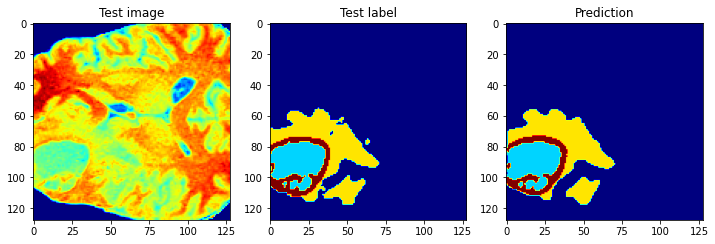

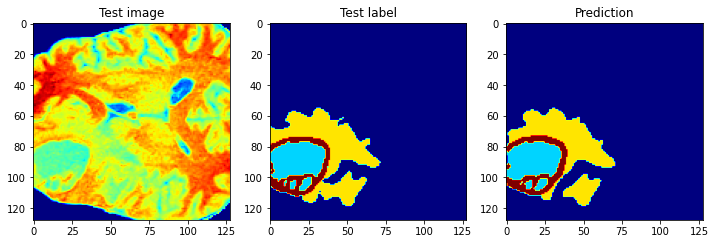

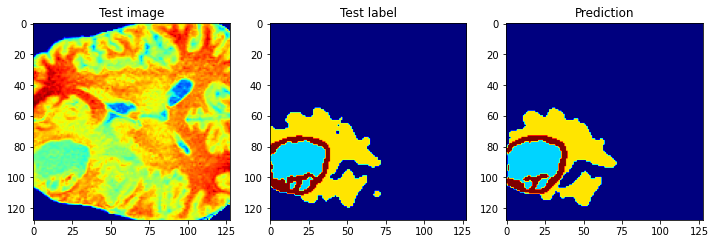

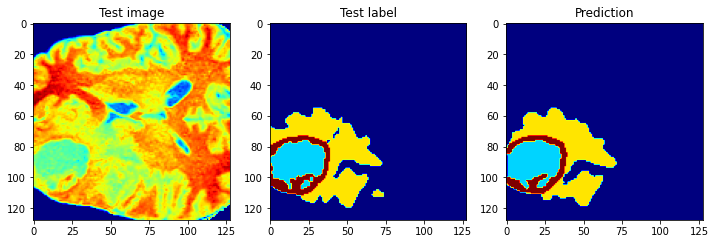

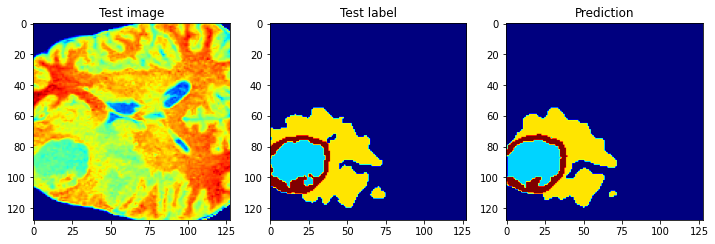

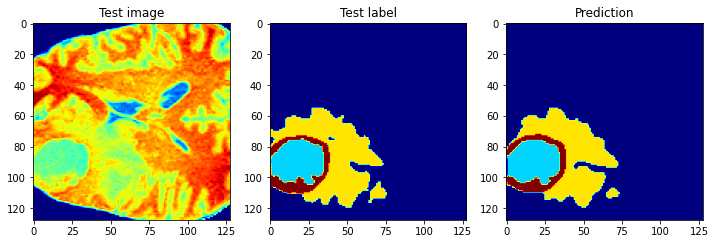

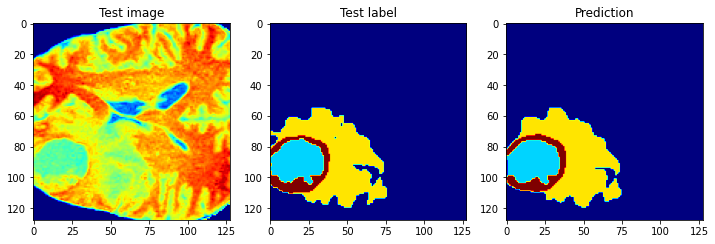

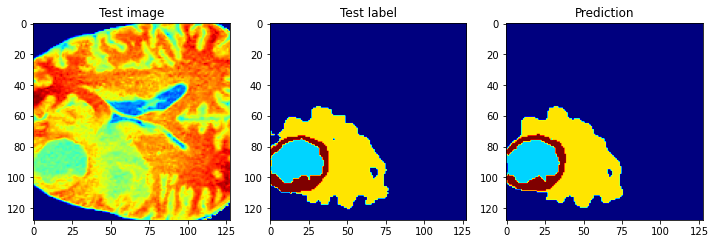

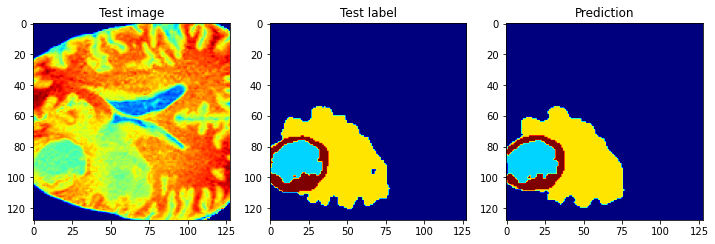

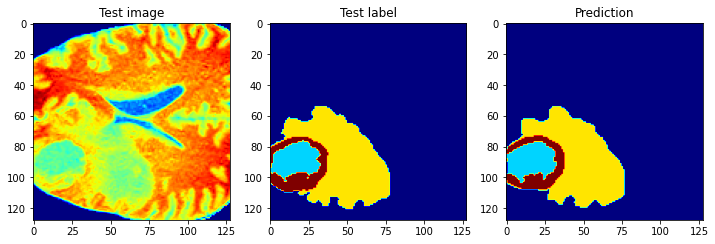

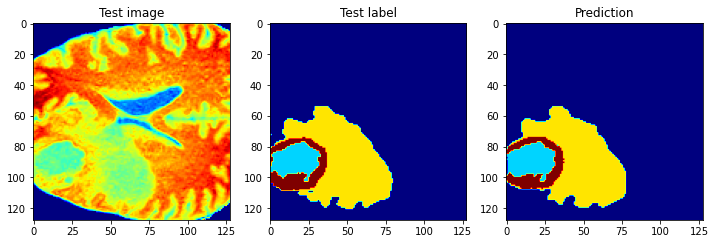

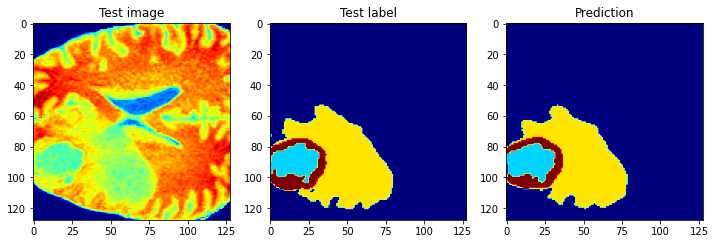

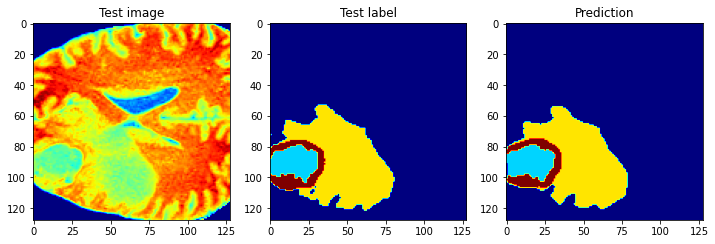

In [17]:
# Plot the test image, mask and prediction
from matplotlib import pyplot as plt
import random

for i in range(51,75):
  num_slice = i
  plt.figure(figsize=(12,10))
  plt.subplot(231)
  plt.title("Test image")
  plt.imshow(test_img[:,:,num_slice,1], cmap = 'jet')
  plt.subplot(232)
  plt.title("Test label")
  plt.imshow(test_mask_argmax[:,:,num_slice], cmap = 'jet')
  plt.subplot(233)
  plt.title("Prediction")
  plt.imshow(test_pred_argmax[:,:,num_slice], cmap = 'jet')
  plt.show()

In [24]:
pd.set_option('max_columns', None)

In [25]:
history = pd.read_csv('/content/History 1.csv')

In [26]:
print(history.head(0))

Empty DataFrame
Columns: [epoch, HD95, HD95_et, HD95_tc, HD95_wt, accuracy, dice_coef, dice_coef_et, dice_coef_tc, dice_coef_wt, loss, lr, one_hot_mean_io_u, sensitivity, sensitivity_et, sensitivity_tc, sensitivity_wt, specificity, specificity_et, specificity_tc, specificity_wt, val_HD95, val_HD95_et, val_HD95_tc, val_HD95_wt, val_accuracy, val_dice_coef, val_dice_coef_et, val_dice_coef_tc, val_dice_coef_wt, val_loss, val_one_hot_mean_io_u, val_sensitivity, val_sensitivity_et, val_sensitivity_tc, val_sensitivity_wt, val_specificity, val_specificity_et, val_specificity_tc, val_specificity_wt]
Index: []


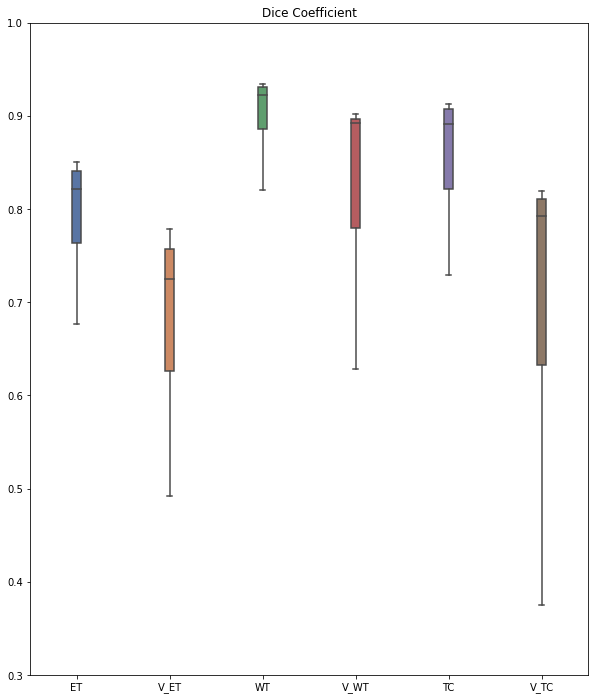

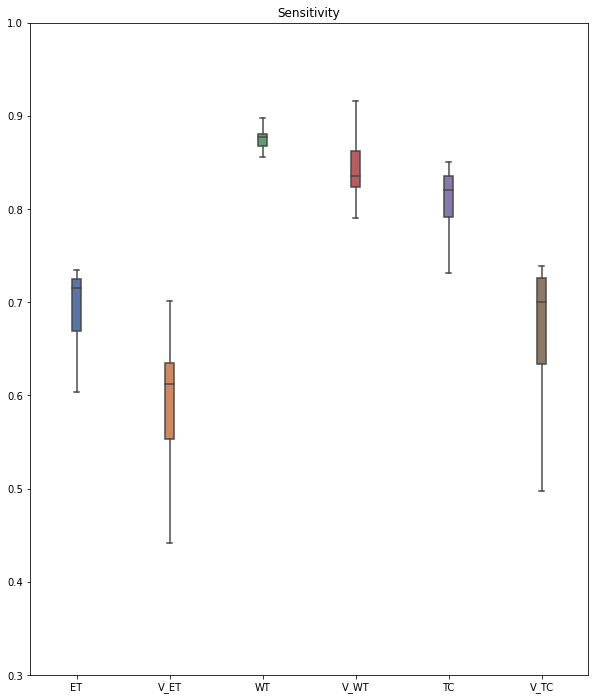

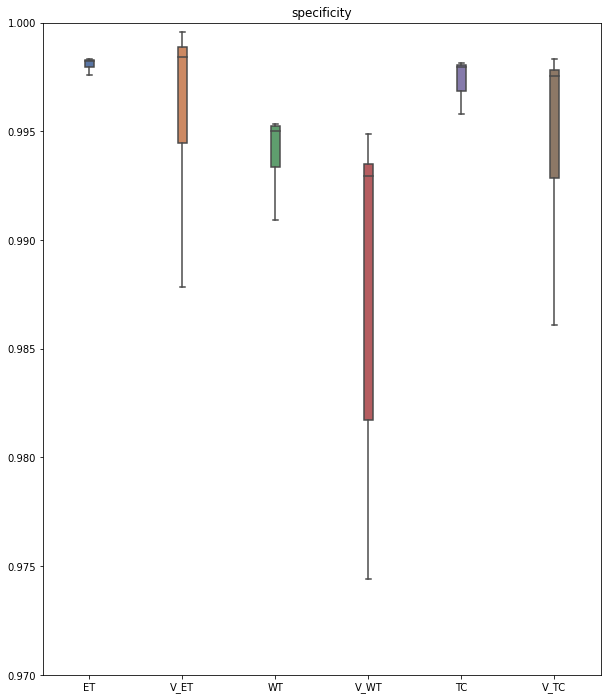

In [65]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
  
plt.figure(figsize=(10, 12))

# Create a boxplot with two boxes
ax = sns.boxplot(data=history[['dice_coef_et','val_dice_coef_et','dice_coef_wt','val_dice_coef_wt','dice_coef_tc','val_dice_coef_tc']], palette='deep', width=0.1,fliersize=0)
plt.title('Dice Coefficient')
plt.ylim(0.3,1.0)

ax.set_xticklabels(['ET', 'V_ET', 'WT', 'V_WT', 'TC', 'V_TC'])

plt.show()

plt.figure(figsize=(10, 12))

# Create a boxplot with two boxes
ax = sns.boxplot(data=history[['sensitivity_et','val_sensitivity_et','sensitivity_wt','val_sensitivity_wt','sensitivity_tc','val_sensitivity_tc']], palette='deep', width=0.1,fliersize=0)
plt.title('Sensitivity')
plt.ylim(0.3,1.0)

ax.set_xticklabels(['ET', 'V_ET', 'WT', 'V_WT', 'TC', 'V_TC'])

plt.show()

plt.figure(figsize=(10, 12))

# Create a boxplot with two boxes
ax = sns.boxplot(data=history[['specificity_et','val_specificity_et','specificity_wt','val_specificity_wt','specificity_tc','val_specificity_tc']], palette='deep', width=0.1,fliersize=0)
plt.title('specificity')
plt.ylim(0.97,1.0)

ax.set_xticklabels(['ET', 'V_ET', 'WT', 'V_WT', 'TC', 'V_TC'])

plt.show()